In [1]:
import math
import copy
import torch
import random
import argparse

import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from math import sqrt
from tqdm import tqdm
from scipy.stats import mode

from scipy.special import softmax

from utils import (
    generate_x,
    generate_y,
    conduct_gd_noise,
    combine_input,
    
    SimpleAttn,
)



## case 1: gd with noise

$$
\Delta w_t = g_t + \xi^\top w_t \xi, ~~~   \xi \in \mathcal{N}(\delta^2 I, 0)\\
w_{t+1} = w_t - \eta \Delta w_t
$$

(1.2856544494628905, 1.4856544494628907)

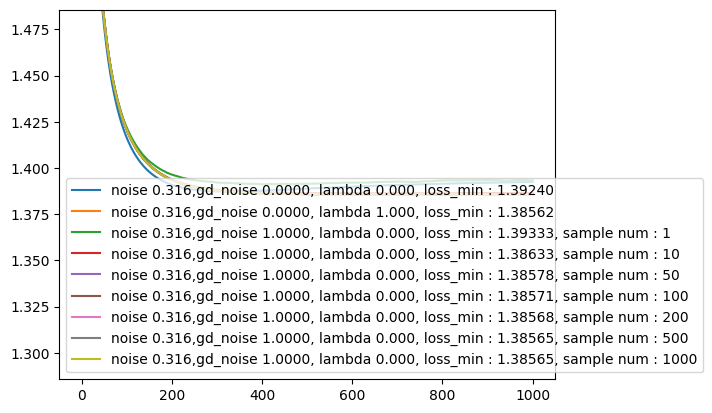

In [ ]:

def gd_noise_nwn(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.1) 
cot_steps   = 1000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 1001

# def random_mask(weight, device, choose_elements):
#     b, c, _ = weight.size()
#     threshold = torch.rand(b, c, device=device).topk(choose_elements, dim=-1, largest=False).values[:, -1]
#     weight_mask = torch.rand(b, c, device=device) > threshold.unsqueeze(-1)
#     weight[weight_mask] = 0
#     return weight


opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    for gd_noise in [opt_lbda]:
        w_samples = torch.zeros_like(w_cot)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nwn )
            w_samples += w_cot
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_samples/(it + 1) -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

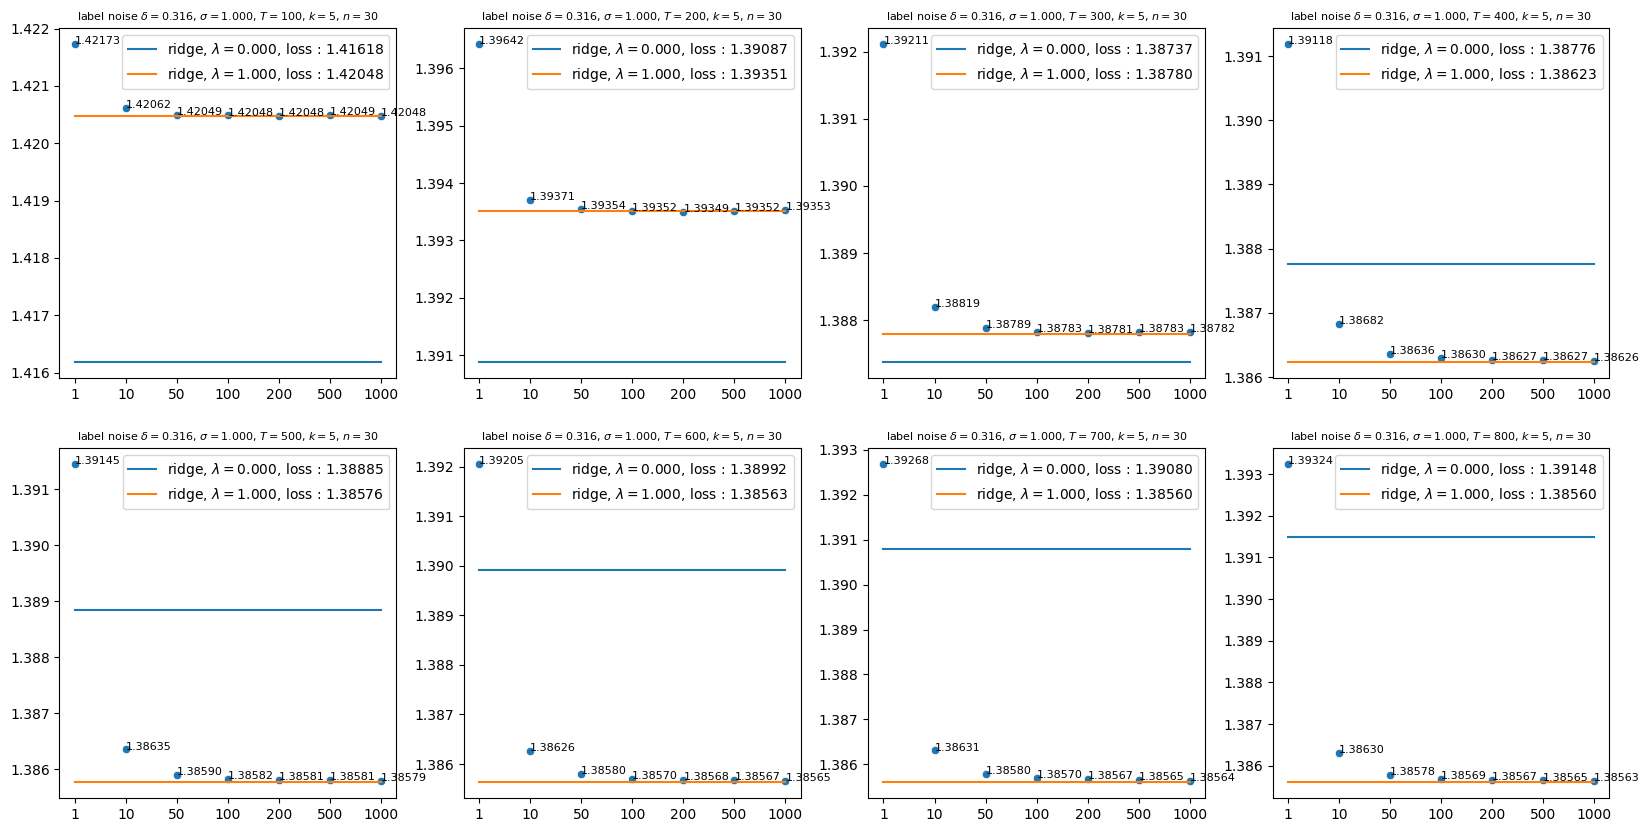

In [ ]:
eval_step= 500
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)
    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)

In [257]:
noise**2 *  x_dim/ choose_elements

3.125

## case 1.2: use reward function $f(w) = ||w||_2^2$

(1.4697814226150512, 1.6697814226150514)

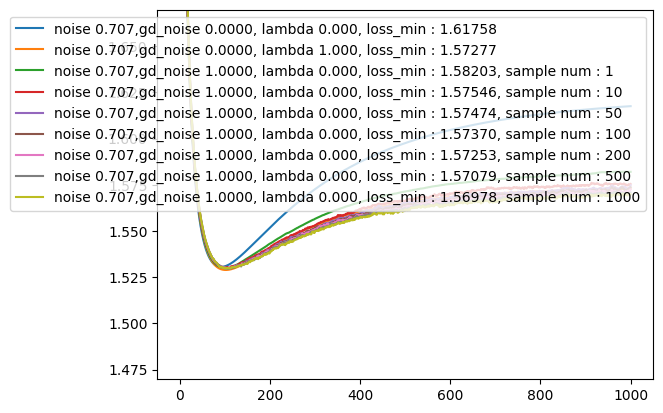

In [ ]:

def gd_noise_nwn(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v

def l2_norm_reward(w_all):
    return w_all.norm(dim = -1)

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.5) 
cot_steps   = 1000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 1001



opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [opt_lbda]:
        w_min = torch.zeros_like(w_cot) + 10000
        w_min_rw = l2_norm_reward(w_min)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nwn )
            w_cot_norm = l2_norm_reward(w_cot)
            mask = w_min_rw > w_cot_norm
            w_min[mask] = w_cot[mask]
            w_min_rw[mask] = w_cot_norm[mask]
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_min -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

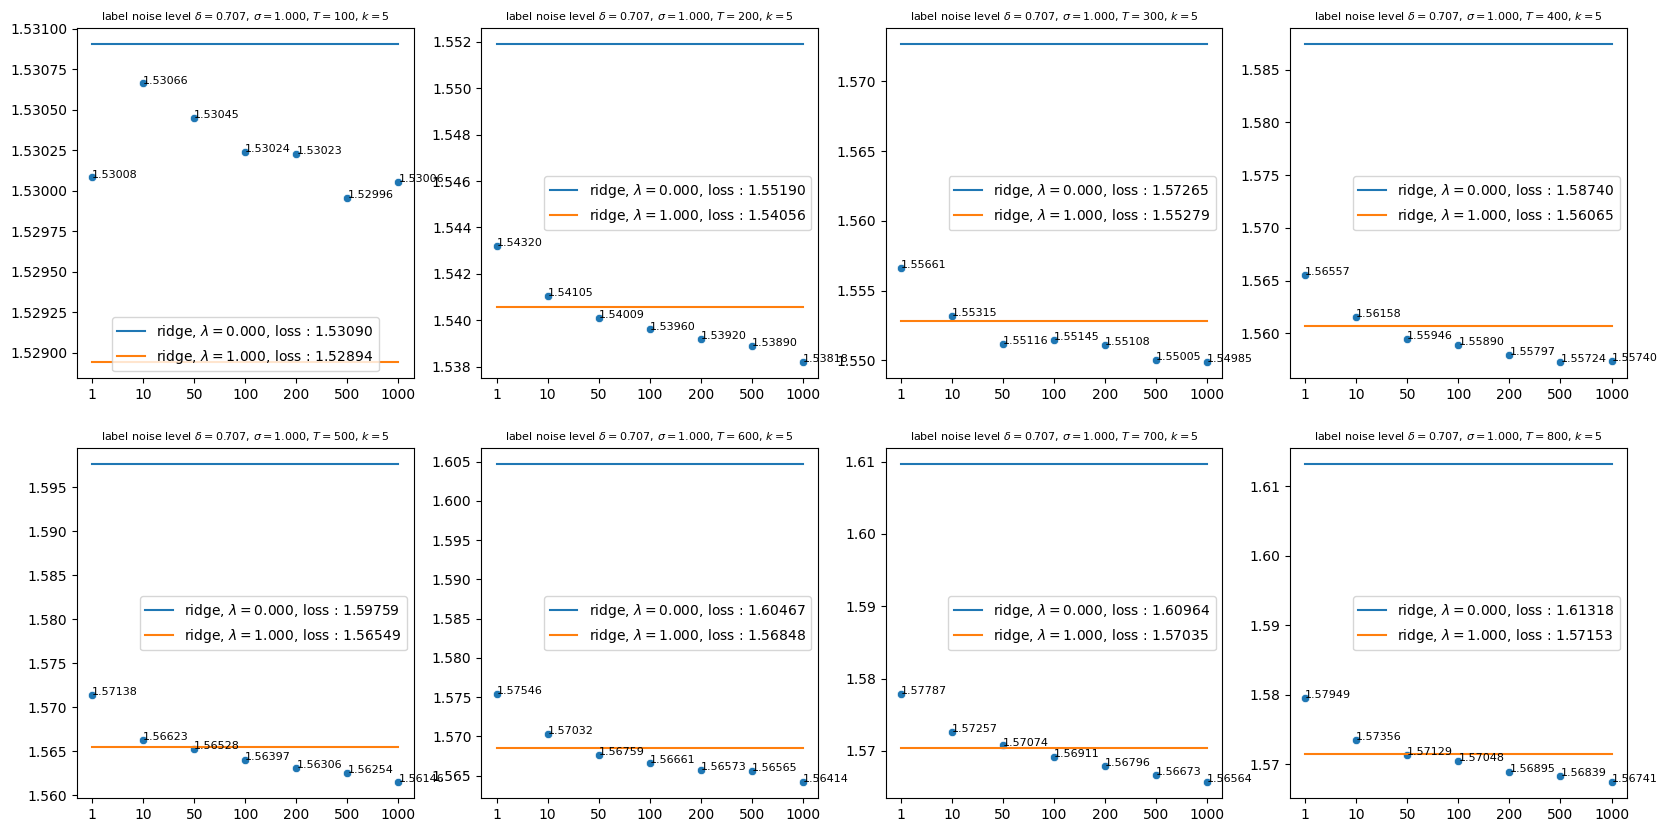

In [6]:
eval_step= 500
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise level $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$", fontsize=8)

## case 1.3

$$
\Delta w_t = g_t + \xi, ~~~   \xi \in \mathcal{N}(\delta^2 I, 0)\\
w_{t+1} = w_t - \eta \Delta w_t
$$

(1.4466318130493163, 1.6466318130493165)

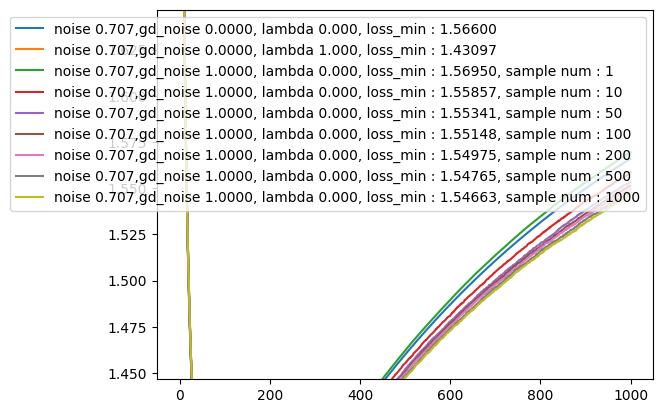

In [ ]:
def gd_noise_nw(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return gd_noise_v

def l2_norm_reward(w_all):
    return w_all.norm(dim = -1)

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 40
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.5) 
cot_steps   = 1000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 1001

opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [opt_lbda]:
        w_min = torch.zeros_like(w_cot) + 10000
        w_min_rw = l2_norm_reward(w_min)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = gd_noise, gd_noise_func = gd_noise_nw )
            w_cot_norm = l2_norm_reward(w_cot)
            mask = w_min_rw > w_cot_norm
            w_min[mask] = w_cot[mask]
            w_min_rw[mask] = w_cot_norm[mask]
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_min -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

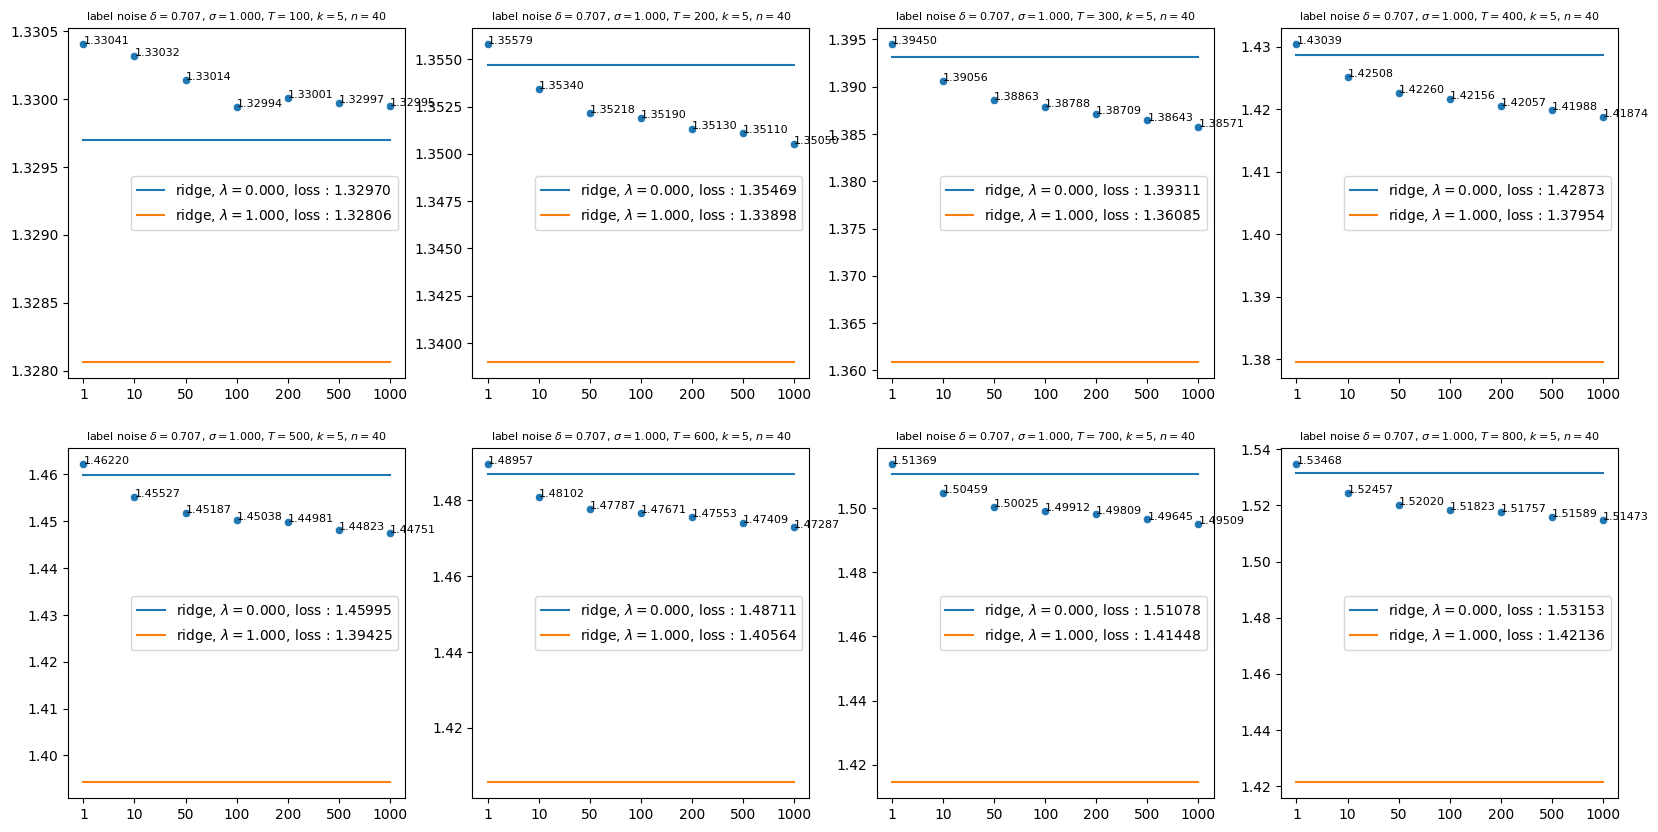

In [9]:
eval_step= 500
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)

## case 1.4: sparse linear regression with binary coeffcient

$$
w^\star = [0,1,0,0,1,\cdots] \in \{0,1\}^d
$$

(1.3731440544128417, 1.5731440544128419)

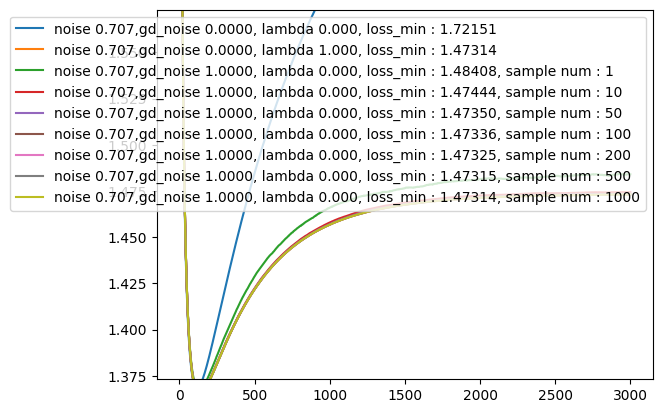

In [ ]:

def gd_noise_nwn(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v


device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 40
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.5) 
cot_steps   = 3000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
w_all = torch.zeros(batch_num, x_dim, device = device)
w_all[:, ::(x_dim // choose_elements)] = 1
y_context = torch.einsum('bnf,bf->bn', x_context, w_all)[:,:,None]
y_context += torch.randn_like(y_context, device = device) * noise
sample_num  = 1001

opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    for gd_noise in [opt_lbda]:
        w_samples = torch.zeros_like(w_cot)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nwn )
            w_samples += w_cot
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_samples/(it + 1) -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

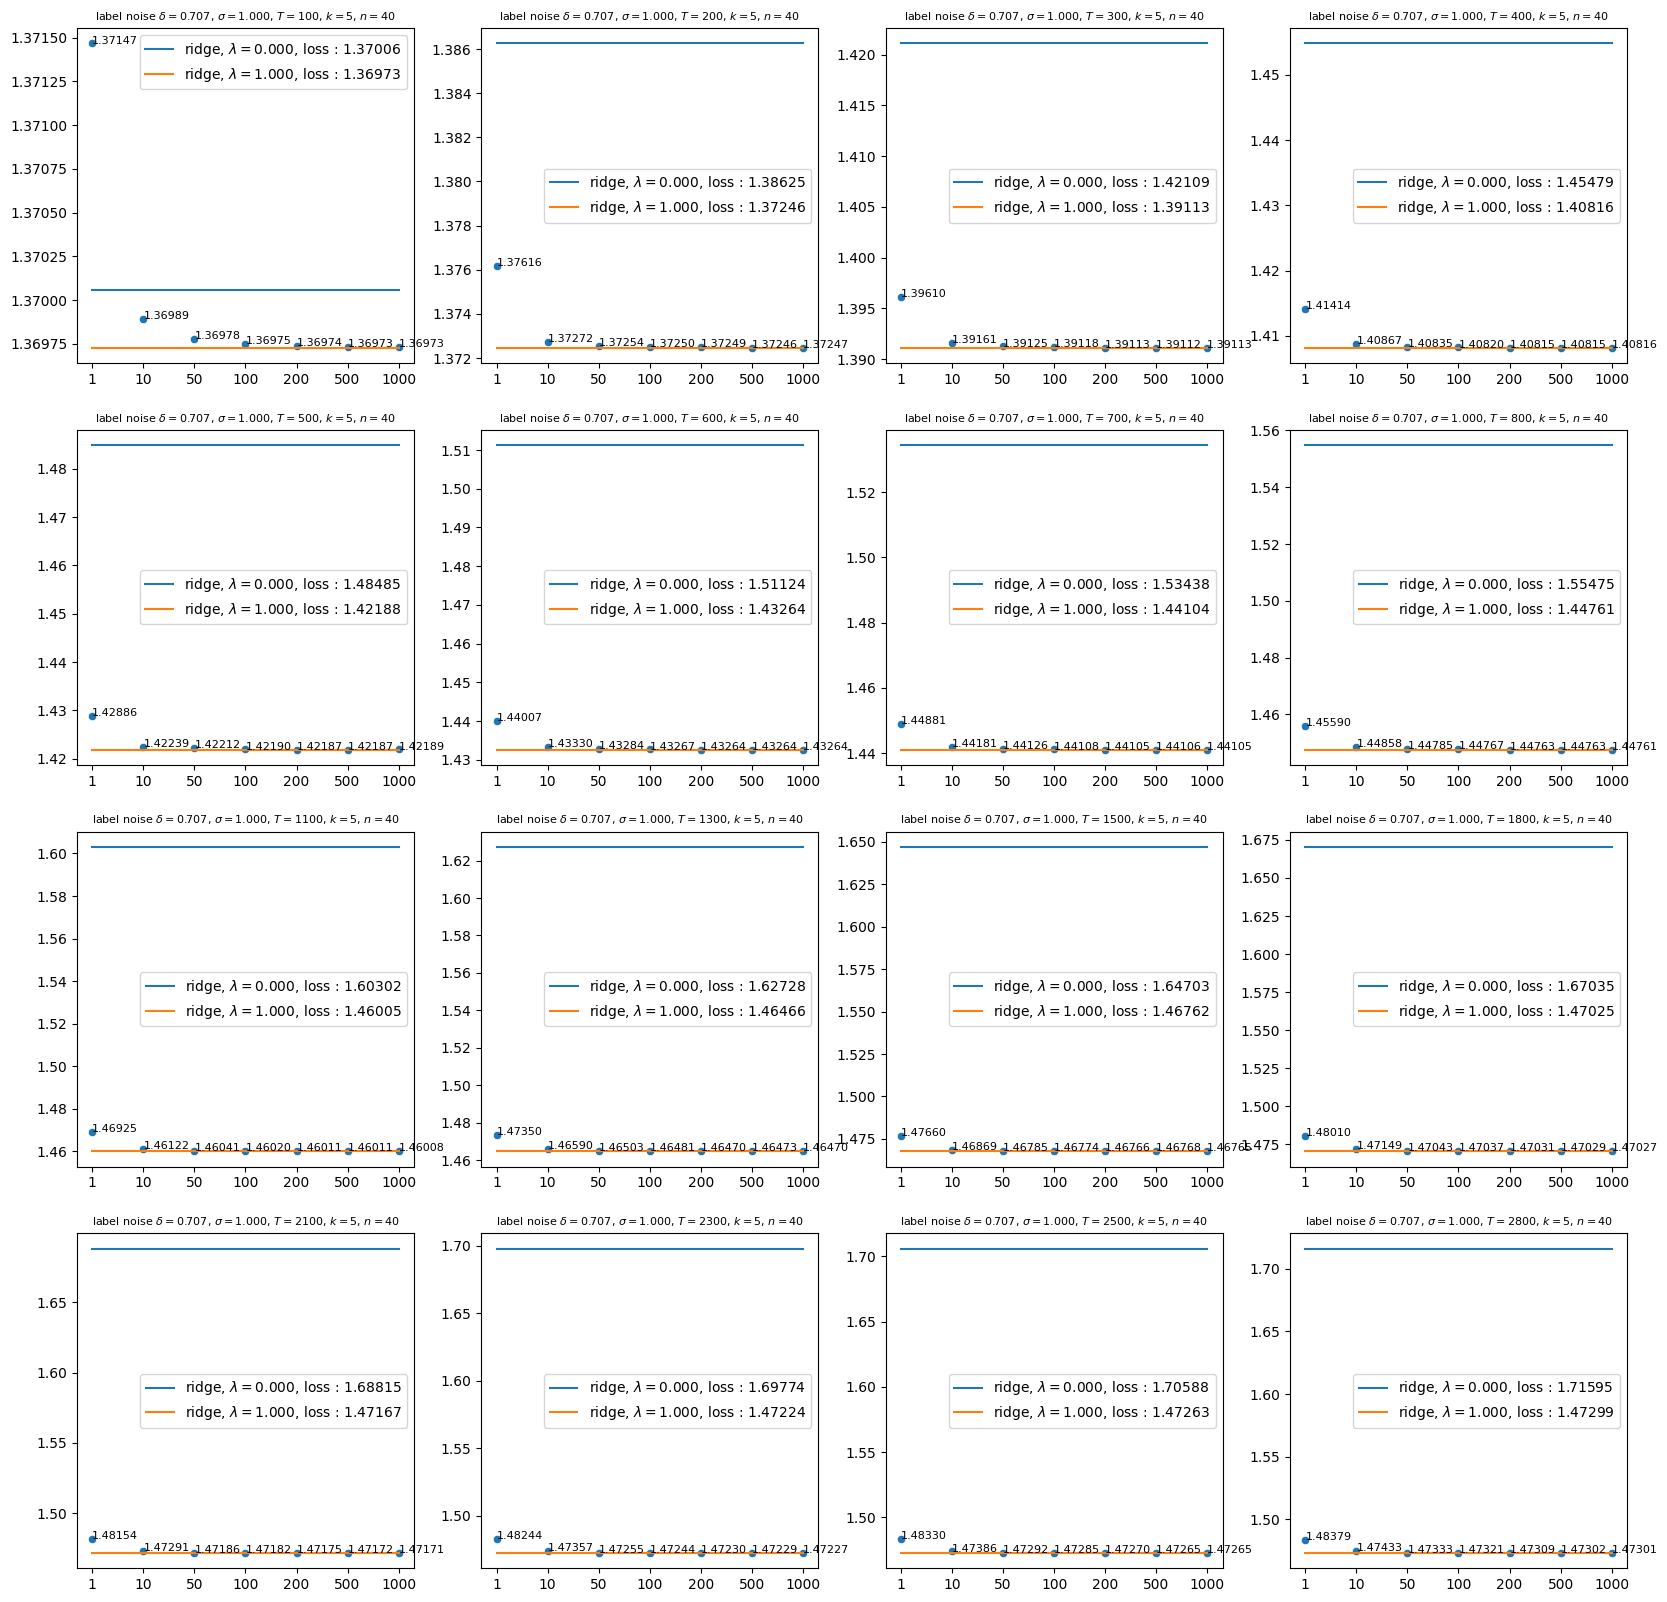

In [11]:
eval_step= 500
fig, axes = plt.subplots(4, 4, figsize=(5 * 4, 5 * 4))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800, 1100,1300,1500,1800, 2100,2300,2500,2800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)

(1.3535889625549316, 1.5535889625549317)

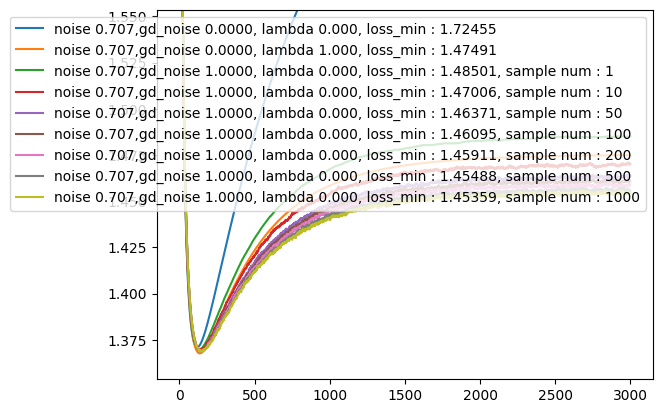

In [ ]:
def gd_noise_nwn(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v

def l2_norm_reward(w_all):
    return w_all.norm(dim = -1)

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 40
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.5) 
cot_steps   = 3000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
w_all = torch.zeros(batch_num, x_dim, device = device)
w_all[:, ::(x_dim // choose_elements)] = 1
y_context = torch.einsum('bnf,bf->bn', x_context, w_all)[:,:,None]
y_context += torch.randn_like(y_context, device = device) * noise
sample_num  = 1001


opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [opt_lbda]:
        w_min = torch.zeros_like(w_cot) + 10000
        w_min_rw = l2_norm_reward(w_min)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nwn )
            w_cot_norm = l2_norm_reward(w_cot)
            mask = w_min_rw > w_cot_norm
            w_min[mask] = w_cot[mask]
            w_min_rw[mask] = w_cot_norm[mask]
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_min -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

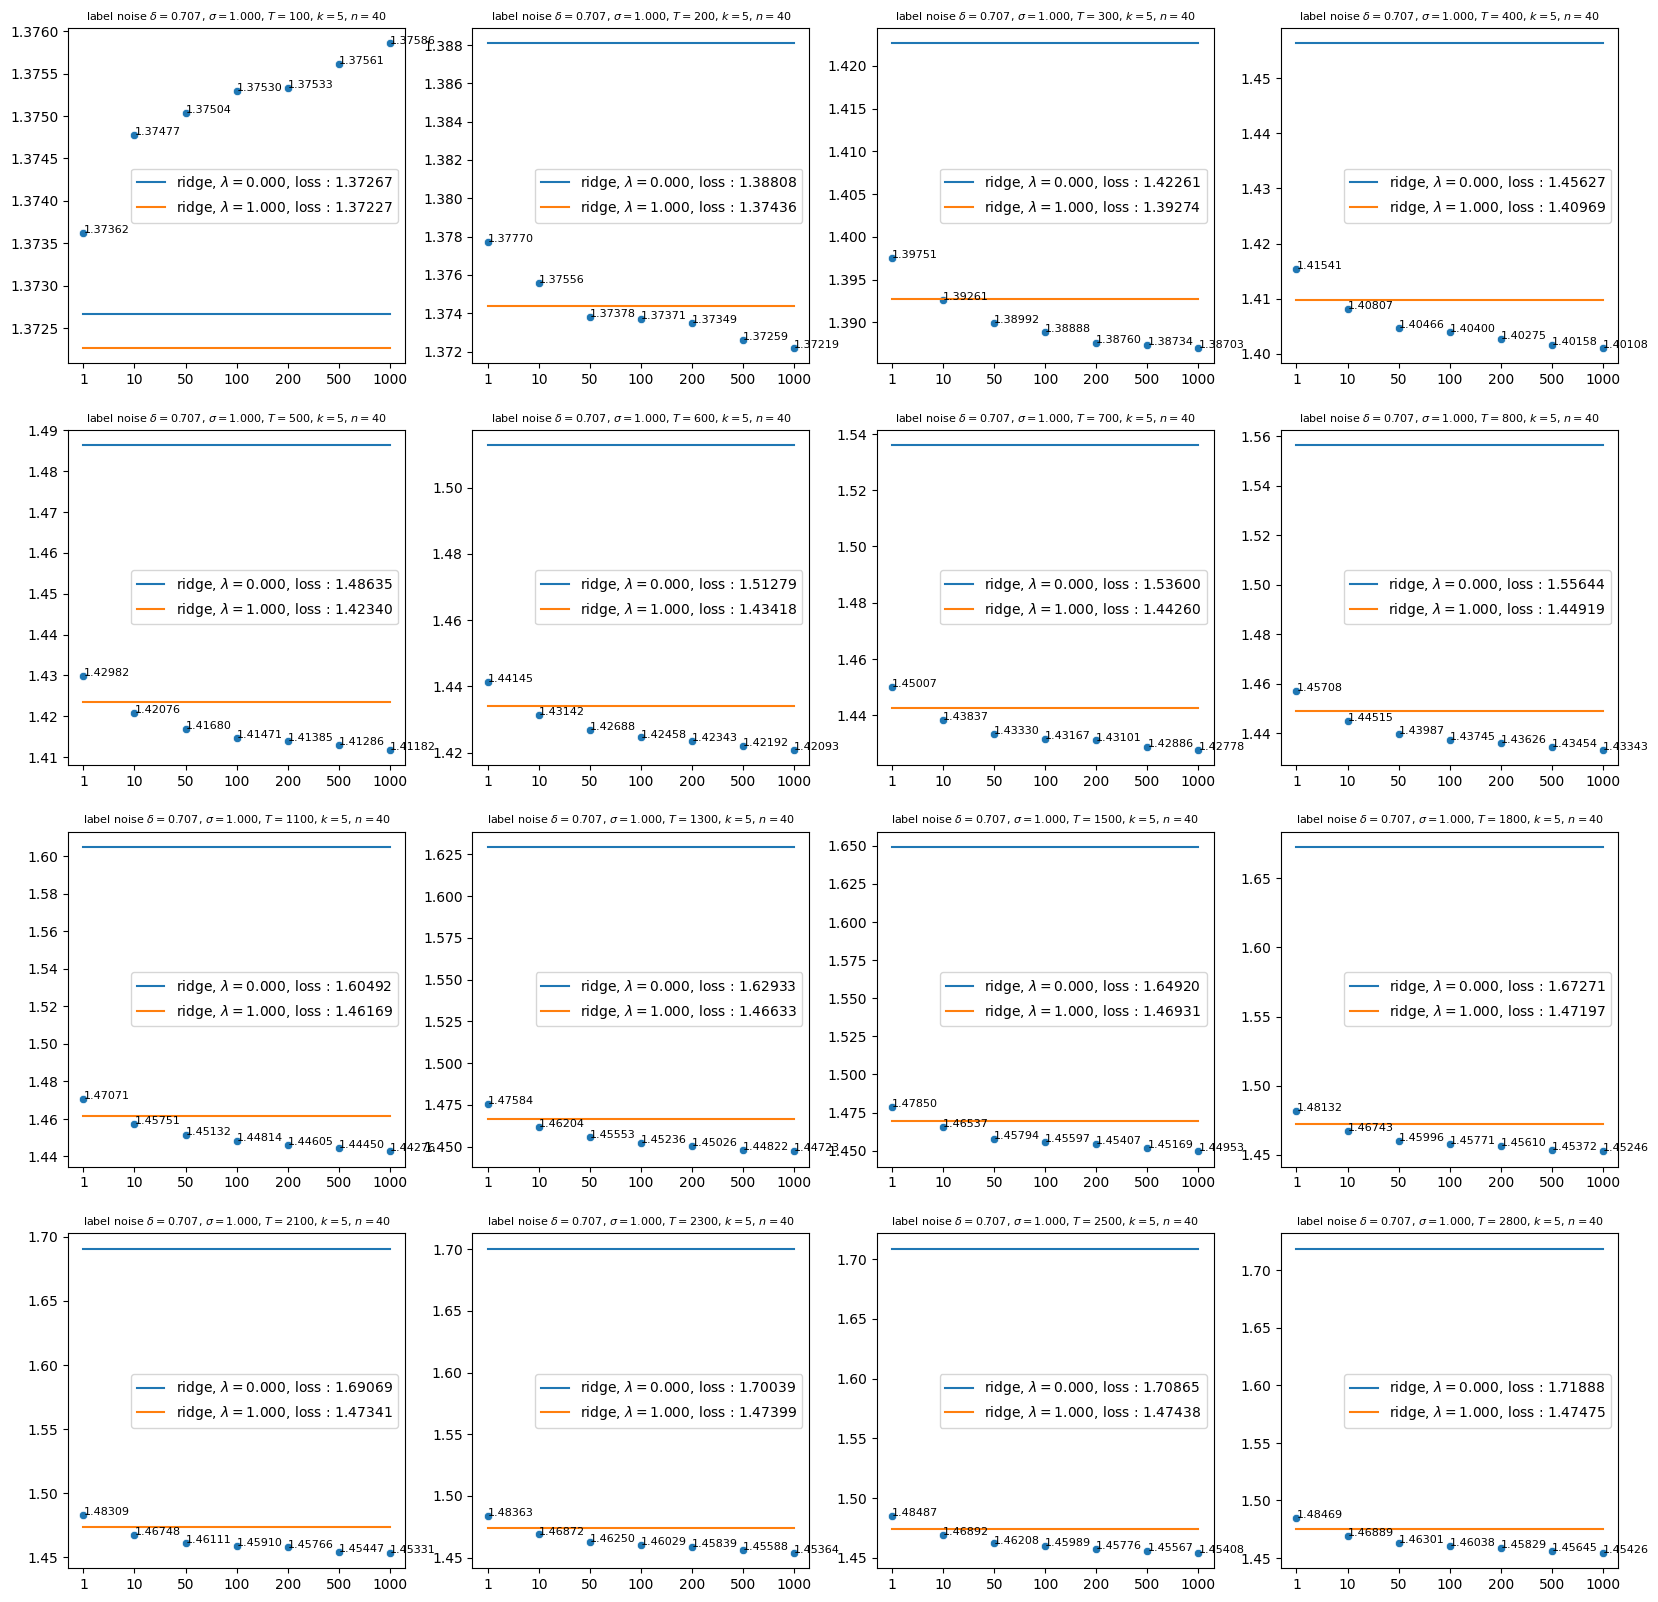

In [13]:
eval_step= 500
fig, axes = plt.subplots(4, 4, figsize=(5 * 4, 5 * 4))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800, 1100,1300,1500,1800, 2100,2300,2500,2800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)



## case 1.5: gd with sign-based noise

$$
\Delta w_t = g_t + \xi^\top \text{sign} (w_t)  \xi, ~~~   \xi \in \mathcal{N}(\delta^2 I, 0)\\
w_{t+1} = w_t - \eta \Delta w_t
$$

(1.0645542383193969, 1.264554238319397)

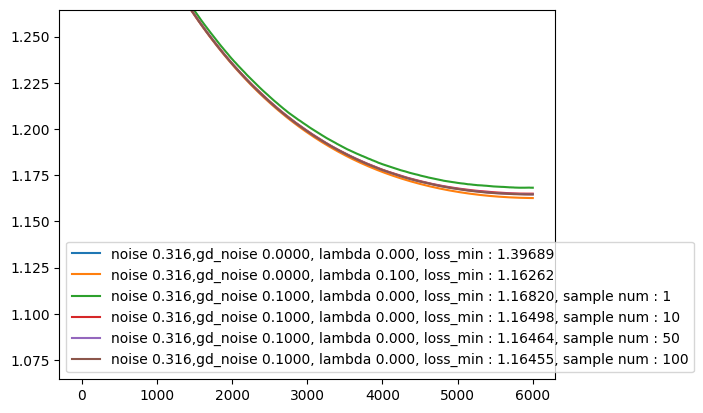

In [ ]:

def gd_noise_w_sign(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    wi_sign = (wi > 0).to(gd_noise_v.dtype)
    return (gd_noise_v.transpose(1, 2) @ wi_sign) * gd_noise_v

def gd_reg_w_sign(gd_noise,wi,device):
    wi_sign = (wi > 0).to(wi.dtype)
    return wi_sign * gd_noise


device      = "cuda:1"
# device      = "cpu"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.1) 
cot_steps   = 6000
gd_noise    = 0.
weight_range= 1

# x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
# w_all = torch.zeros(batch_num, x_dim, device = device)
# w_all[:, ::(x_dim // choose_elements)] = 1
# y_context = torch.einsum('bnf,bf->bn', x_context, w_all)[:,:,None]
# y_context += torch.randn_like(y_context, device = device) * noise

# def random_mask(weight, device, choose_elements):
#     b, c, _ = weight.size()
#     threshold = torch.rand(b, c, device=device).topk(choose_elements, dim=-1, largest=False).values[:, -1]
#     weight_mask = torch.rand(b, c, device=device) > threshold.unsqueeze(-1)
#     weight[weight_mask] = 0
#     return weight


opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
    y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
    sample_num  = 101
    for lbda in [0,opt_lbda*0.1]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = lbda, gd_noise_func = gd_reg_w_sign)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    for gd_noise in [opt_lbda * 0.1]:
        w_samples = torch.zeros_like(w_cot)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_w_sign )
            w_samples += w_cot
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_samples/(it + 1) -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

In [5]:
torch.cuda.empty_cache()

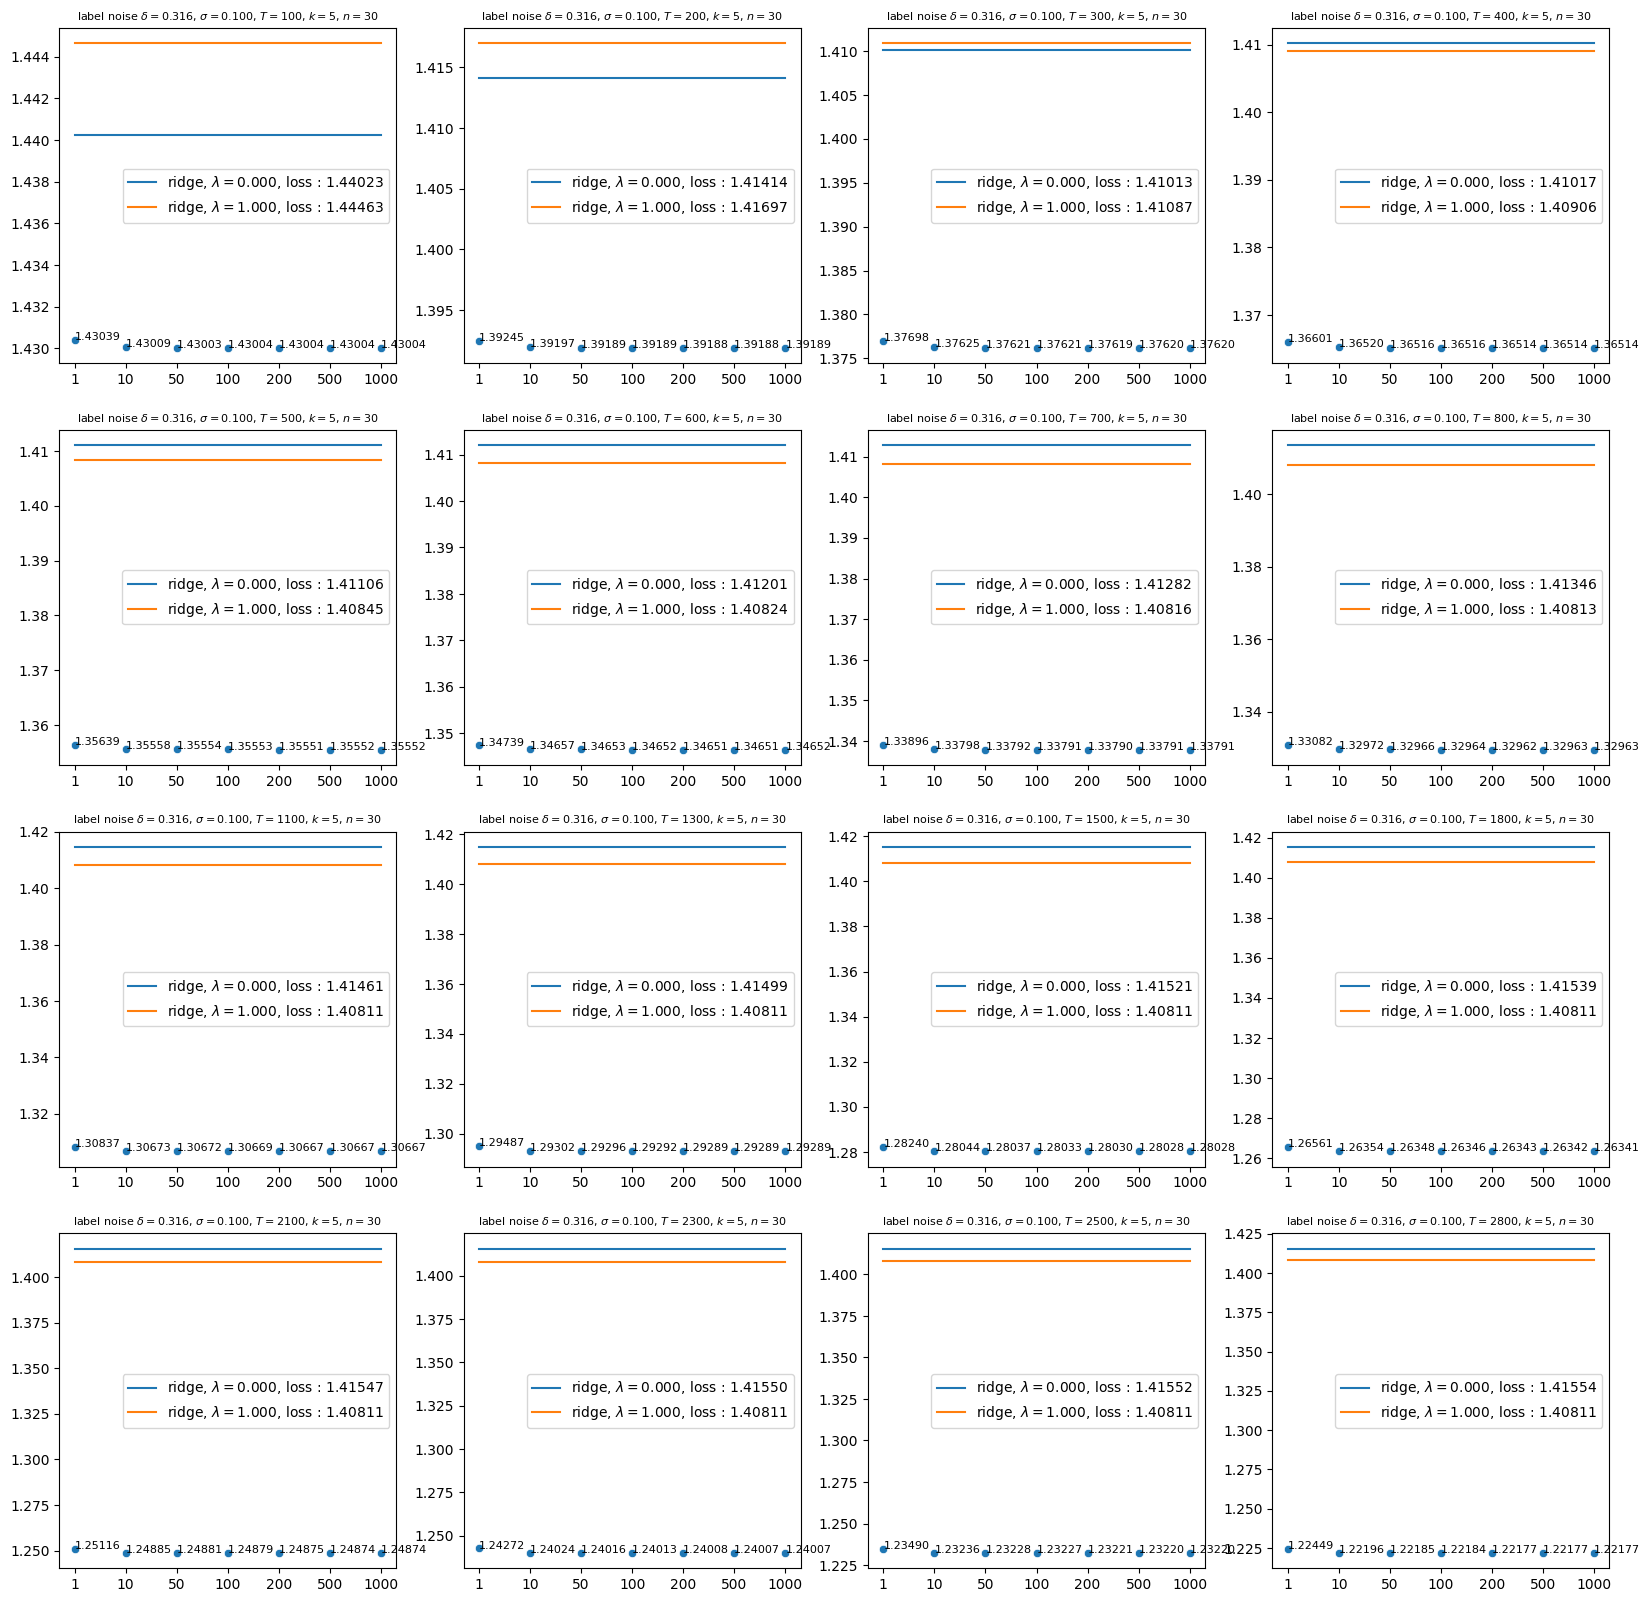

In [4]:
eval_step= 500
fig, axes = plt.subplots(4, 4, figsize=(5 * 4, 5 * 4))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800, 1100,1300,1500,1800, 2100,2300,2500,2800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)



## case 1.6: use reward function $f(w) = ||w||_1^1$

(1.2020023107528686, 1.4020023107528687)

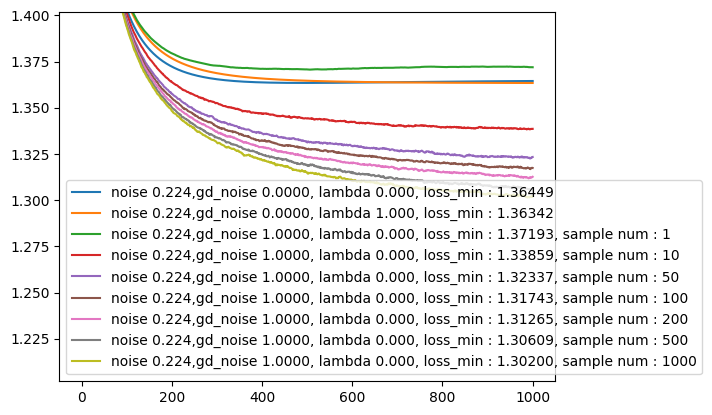

In [ ]:

def gd_noise_nwn(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v

def l1_norm_reward(w_all):
    return w_all.norm(dim = -1, p = 1)

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.05) 
cot_steps   = 1000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 1001



opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [opt_lbda]:
        w_min = torch.zeros_like(w_cot) + 10000
        w_min_rw = l1_norm_reward(w_min)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nwn )
            w_cot_norm = l1_norm_reward(w_cot)
            mask = w_min_rw > w_cot_norm
            w_min[mask] = w_cot[mask]
            w_min_rw[mask] = w_cot_norm[mask]
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_min -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

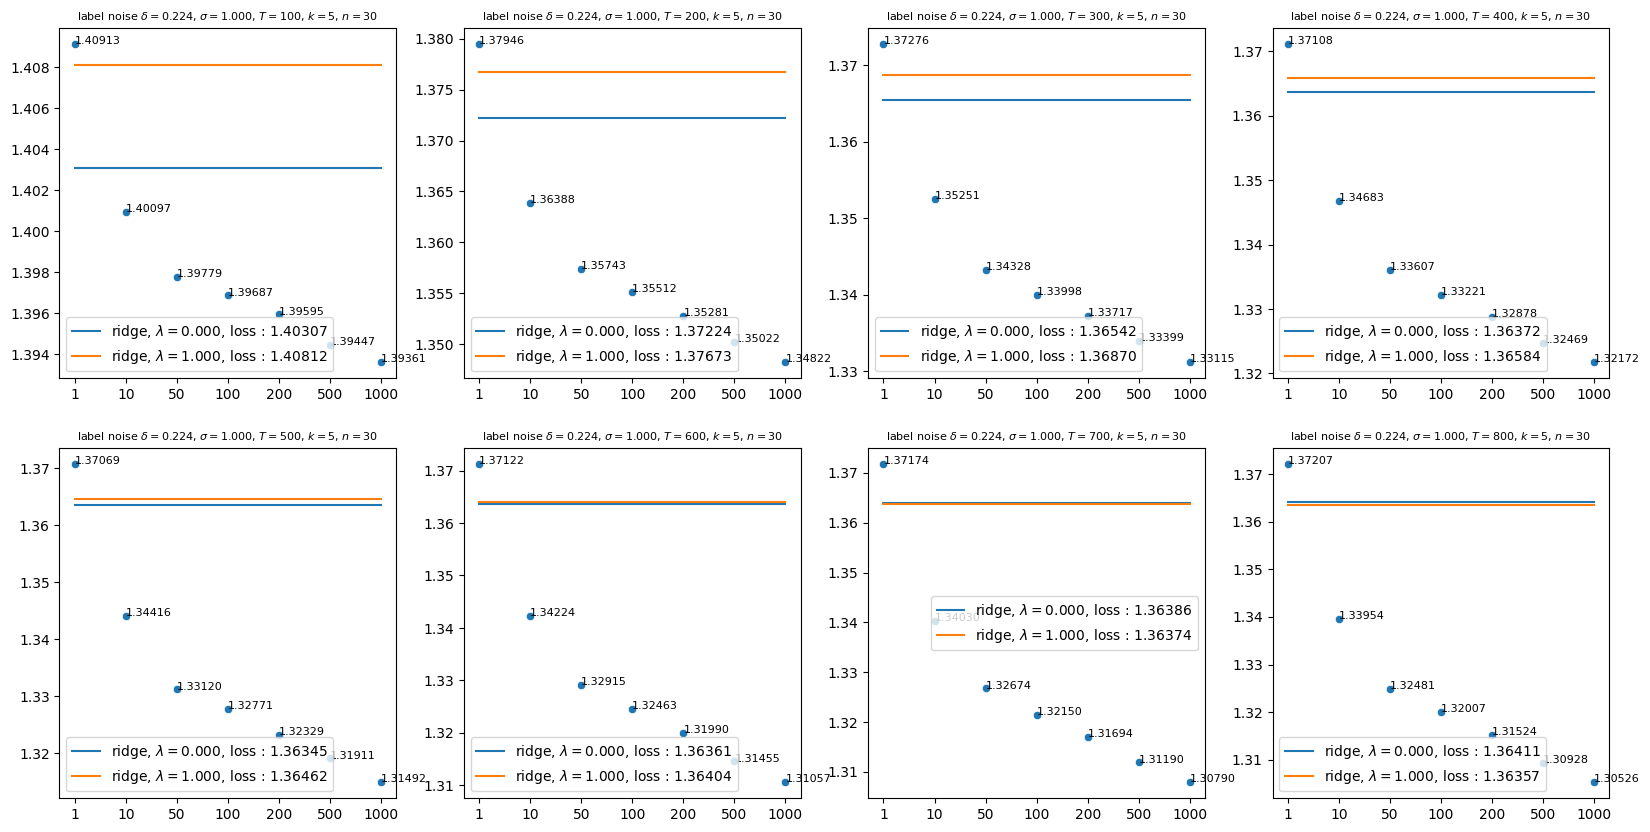

In [17]:
eval_step= 500
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)

(1.2527902364730834, 1.4527902364730836)

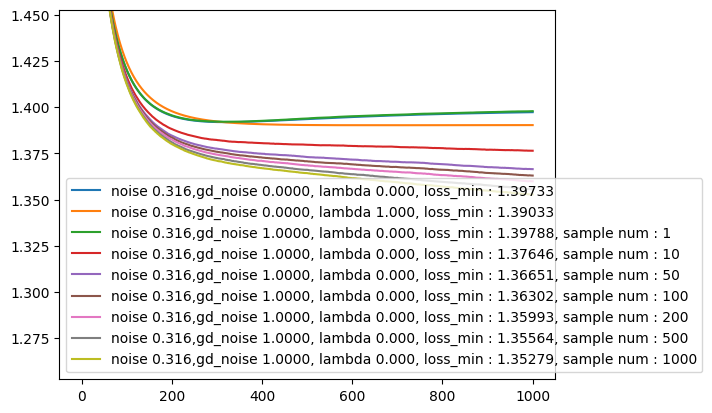

In [ ]:

def gd_noise_nw(gd_noise,wi,device):
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    return wi * gd_noise_v

def l1_norm_reward(w_all):
    return w_all.norm(dim = -1, p = 1)

device      = "cuda:1"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1e-3
lbda        = 0.
noise       = math.sqrt(0.1) 
cot_steps   = 1000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 1001



opt_lbda = 1
eval_loss_all = []
with torch.no_grad():
    for lbda in [0,opt_lbda]:
        w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
        eval_loss_all += [loss.copy()]
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [opt_lbda]:
        w_min = torch.zeros_like(w_cot) + 10000
        w_min_rw = l1_norm_reward(w_min)
        for it in range(sample_num):
            w_cot = conduct_gd_noise(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = math.sqrt(gd_noise), gd_noise_func = gd_noise_nw )
            w_cot_norm = l1_norm_reward(w_cot)
            mask = w_min_rw > w_cot_norm
            w_min[mask] = w_cot[mask]
            w_min_rw[mask] = w_cot_norm[mask]
            if (it + 1) in [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]:
                loss = (w_min -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
                eval_loss_all += [loss.copy()]
                sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}, sample num : {it+1}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

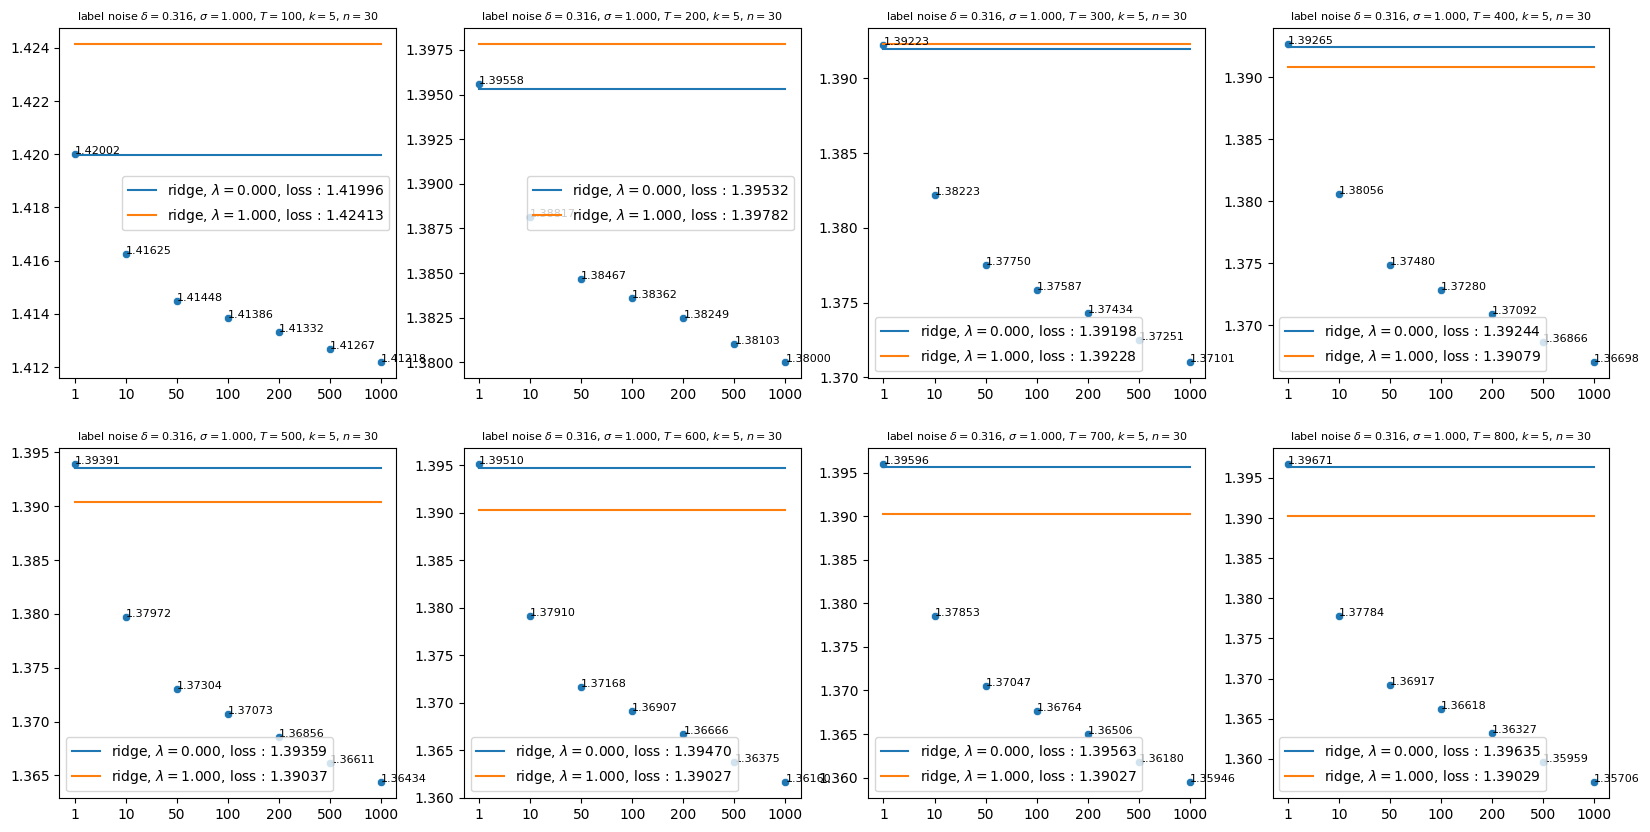

In [4]:
eval_step= 500
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for idx,eval_step in enumerate([100,200,300,400,500,600,700,800]):
    ax = axes[idx // 4, idx % 4]
    loss_all = [i[eval_step] for i in eval_loss_all]
    sample_num_list =  [1,10,50,100,200,500,1000,1500,2000,3000,4000,5000]
    sample_num_list = [str(i) for i in sample_num_list]
    sns.lineplot(x = [0,6], y = [loss_all[0]]*2, label = f"ridge, $\\lambda={0.:.3f}$, loss : {loss_all[0]:.5f}", ax = ax)
    sns.lineplot(x = [0,6], y = [loss_all[1]]*2, label = f"ridge, $\\lambda={opt_lbda:.3f}$, loss : {loss_all[1]:.5f}", ax = ax)
    sns.scatterplot(x =sample_num_list[:len(loss_all[2:])], y = loss_all[2:], ax = ax)

    for x_loc, y_loc in zip(range(10), loss_all[2:]):
        ax.annotate(f"{y_loc:.5f}", (x_loc, y_loc), fontsize=8)

    ax.set_title(f"label noise $\\delta={noise:.3f}$, $\\sigma={gd_noise:.3f}$, $T={eval_step}$, $k={choose_elements}$, $n={example_num}$", fontsize=8)

## case 2: sparse linear regression

### problem setting
$$
w^\star = [0,1,0,0,1,\cdots] \in \{0,1\}^d
$$

<!-- activation to token 
if $\max{|\Delta w_t|} > \delta$:  -->
$$
w_{t+1} = \tilde{w}_t - \eta \Delta w_t \\
\text{sample } k \text{ index based on } w_{t+1}, \text{ set value to 1, otherwise 0 } \rightarrow \tilde{w}_{t+1}
$$

100%|██████████| 1000/1000 [00:36<00:00, 27.37it/s]


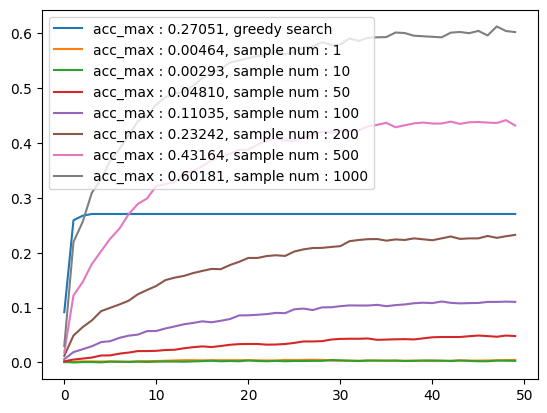

In [63]:
def get_w_bincode(w):
    device = x_context.device
    return (2**torch.arange(w.size(-1),dtype=torch.int64, device = device) * w.to(torch.int64)).sum().item()

device      = "cuda:1"
# device      = "cpu"

x_dim       = 50
batch_num   = 4096
data_range  = 1
example_num = 30
choose_elements = 5
eta         = 1 / example_num
lbda        = 0.
noise       = 1e-2
cot_steps   = 50
weight_range= 1

x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
w_all = torch.zeros(batch_num, x_dim, device = device)
w_all[:, ::(x_dim // choose_elements)] = 1
w_bincode = get_w_bincode(w_all[0])
y_context = torch.einsum('bnf,bf->bn', x_context, w_all)[:,:,None]
y_context += torch.randn_like(y_context, device = device) * noise

sample_num  = 1000



def conduct_gd_discrete(x_context, y_context, eta, w0=None, steps=1, select_method="sample", choose_elements = 1):
    device = x_context.device
    b, t, c = x_context.size()
    encode_list = 2**torch.arange(c,dtype=torch.int64, device = device)
    encode_list = encode_list[None,:]
    if w0 is None:
        wi = torch.zeros((b, c, 1), device=device)
    else:
        wi = w0

    x_context_t = x_context.transpose(1, 2)  # b * c * t
    w_cot = []
    
    for i in range(steps):
        # Gradient update
        wi -= eta * (x_context_t @ (x_context @ wi - y_context))
        wi = wi.clip(min=1e-10)  # Prevents division by zero
        wi /= wi.sum(dim=1, keepdim=True)  # Normalize weights
        if select_method == "sample":
            indices = torch.multinomial(wi.squeeze(-1), num_samples=choose_elements, replacement=False)
        elif select_method == "greedy":
            indices = wi.squeeze(-1).topk(choose_elements, dim=-1).indices  # Top-k greedy selection
        else:
            raise NotImplementedError("Unknown selection method: {}".format(select_method))
        assert indices.size(-1) == choose_elements
        wi = torch.zeros((b, c), device=device)
        wi[torch.arange(b, device=device).unsqueeze(1), indices] = 1
        wi_encode = (encode_list * wi.to(torch.int64)).sum(dim = -1).cpu().numpy()
        wi = wi.unsqueeze(-1)  # Restore original shape (b, c, 1)
        w_cot.append(wi_encode[:, None].copy())
    w_cot = np.concatenate(w_cot, axis = 1)
    return w_cot

opt_lbda = 1
w_pre = []
acc_all = []
with torch.no_grad():
    w_cot = conduct_gd_discrete(x_context, y_context, eta , w0 = None, steps = cot_steps, select_method = "greedy", choose_elements = choose_elements)
    acc = (w_cot == w_bincode).squeeze().sum(axis = 0) / w_cot.shape[0]
    acc_all += [acc]
    sns.lineplot(x = np.arange(len(acc)), y = acc, label = f"acc_max : {acc[-1]:.5f}, greedy search")
    for it in tqdm(range(sample_num)):
        w_cot = conduct_gd_discrete(x_context, y_context, eta , w0 = None, steps = cot_steps, select_method = "sample", choose_elements = choose_elements)
        w_pre += [w_cot[:,None,:]]
        if (it + 1) in [1,10,50,100,200,500,1000]:
            majority_values = mode(np.concatenate(w_pre, axis = 1), axis=1, keepdims = False).mode
            acc = (majority_values == w_bincode).squeeze().sum(axis = 0) / majority_values.shape[0]
            acc_all += [acc]
            sns.lineplot(x = np.arange(len(acc)), y = acc, label = f"acc_max : {acc[-1]:.5f}, sample num : {it+1}")
# w_pre = np.concatenate(w_pre, axis = 1).T

## case 2.2: sparse linear regression (add one item each step)

### problem setting (step by step)
$$
w^\star = [0,1,0,0,1,\cdots] \in \{0,1\}^d
$$

activation $w_{t+1}$ to discrete token $\tilde{w}_{t+1}$:

sample one index for adding: $i \sim  - \Delta w_t$

$$
w_{t+1} = \tilde{w}_t - \eta \Delta w_t
$$

example: 

$$
[0,0,0,0] \rightarrow [1,0,0,0] \rightarrow [1,0,1,0] \rightarrow [1,0,1,1]
$$

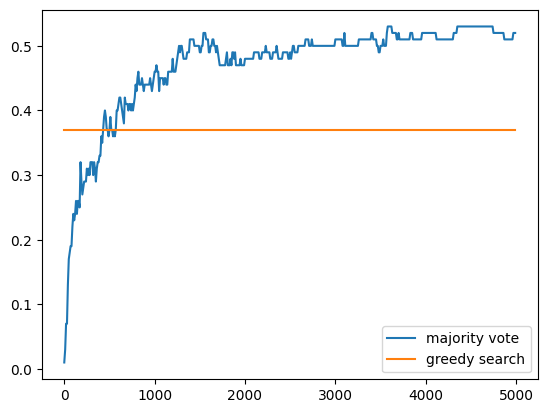

<Axes: >

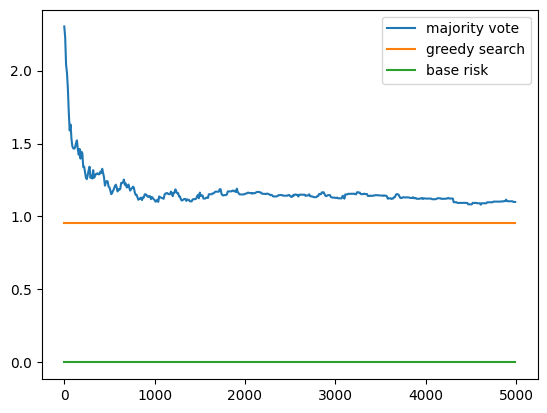

In [20]:
def get_major(count_list):
    count_dict = {}
    max_count = 0
    major_item = 0
    for binary_num in count_list:
        if binary_num in count_dict:
            count_dict[binary_num] += 1
        else:
            count_dict[binary_num] = 1
    for i in count_dict:
        if max_count < count_dict[i]:
            max_count = count_dict[i]
            major_item = i
    return major_item

def count_ones_in_binary(num):
    count = 0
    while num:
        count += num & 1
        num >>= 1
    return count

# Analyze results for each batch
error_lists = []
sample_num_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sample_num_list = np.arange(1,5000,10)
acc_all = []
error_all = []
for k in sample_num_list:
    acc_count = 0
    error_major_item = 0
    for b in range(batch_size):
        true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
        major_item = get_major(count_list[b][:k])
        acc_count += int(major_item == true_item)
        error_major_item += err_dict[b][major_item]
    acc_all += [acc_count / batch_size]
    error_all += [error_major_item / batch_size]
sns.lineplot(x = sample_num_list, y = acc_all, label = "majority vote")
greedy_acc_count = 0
for b in range(batch_size):
    true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
    greedy_acc_count += int(greedy_result[b] == true_item)
greedy_acc = greedy_acc_count / batch_size
sns.lineplot(x=sample_num_list, y=[greedy_acc] * len(sample_num_list), label = "greedy search")
plt.show()

sns.lineplot(x = sample_num_list, y = error_all, label = "majority vote")
sns.lineplot(x=sample_num_list, y=[greedy_errs.mean()] * len(sample_num_list), label = "greedy search")
sns.lineplot(x=sample_num_list, y=[((np.einsum('bnf,bf->bn', X, true_weights) - y)**2).mean()] * len(sample_num_list), label = "base risk")
 